In [360]:
import json
from queue import PriorityQueue
import sys
import math
import numpy as np
from scipy import interpolate

input = 'adj_ncm1_mr18_lps3.json'
with open(input, 'rb') as fp:
    data = json.load(fp)

adj_data = data['adj']
num_NMC = data['num_NMC']
num_LPS = data['num_LPS']
num_particle = data['num_particle']
vertical_dist_data = data['vertical_dist']
particle_rads_data = data['particle_rads']
particle_type_data = data['type']
SYS_thk = data['thickness']

adj = {}
# count = 0
for key in adj_data.keys():
    bool = False
    value = {}
    # if not adj_data[key].keys() and particle_type_data[key] == 'NMC':
    #     count += 1
    for i in adj_data[key].keys():
        # if adj_data[key][i][2] == 'LPS':
        #     bool = True
        value[int(i)] = adj_data[key][i]
    # if not bool and particle_type_data[key] == 'NMC':
    #     count += 1
    adj[int(key)] = value
# print('count', count)  # number of NMC particles that have no neighbor
# print(adj[404])  # last NMC particle has no neighbor particles!

vertical_dist = {int(key): value for key, value in vertical_dist_data.items()}
particle_rads = {int(key): value for key, value in particle_rads_data.items()}
particle_type = {int(key): value for key, value in particle_type_data.items()}

# Helper function


def heuristic(x):
    if x < 0 or x >= num_particle:
        raise IndexError('Index out of bound.')
    return vertical_dist[x]


def path_finder(s):
    if particle_type[s] != 'NMC':
        raise IndexError('Only consider NMC particles!')

    dist_so_far = [float('inf')] * num_particle
    parent = [None] * num_particle

    pq = PriorityQueue()

    dist_so_far[s] = 0
    source = (heuristic(s), s)
    parent[s] = s

    pq.put(source)
    while not pq.empty():
        _, temp = pq.get()
        if particle_type[temp] == 'Target':
            break
        for v in adj[temp].keys():
            if v == parent[temp] or particle_type[v] == 'NMC':
                continue
            dist = dist_so_far[temp] + adj[temp][v][0]
            if dist < dist_so_far[v]:
                parent[v] = temp
                dist_so_far[v] = dist
                pq.put((dist + heuristic(v), v))

    if not parent[-1]:
        return [], float('inf')

    shortest_path = [num_particle - 1]
    path_length = 0
    particle_on_path = num_particle - 1
    while True:
        v = parent[particle_on_path]
        if v == particle_on_path:
            break
        shortest_path.append(v)
        path_length += adj[v][particle_on_path][0]
        particle_on_path = v
    return list(reversed(shortest_path)), path_length
###

In [366]:
# Define parameters
pi      = 3.1415926
# Faradary constant, in unit s*A/mol
cn_F    = 96485.3329
# Density of NMC, in unit g/cm^3
den_ncm = 4.85
# Molar mass of NMC, in unit g/mol
mss_ncm = 96.95406
# Theoretic Specific capacity for NMC, in unit mAh/g
Qs_max  = cn_F/mss_ncm /3.6
#print(Qs_max)

# The current density used in the cell, in unit mA/cm^2
I0      = 0.05
# The area of the model, in unit um^2
A0      = 6400
# Sgm is the conductivity of bulkLPS 0.3mS/cm, here in unit S/um
sgm     = 3*1e-8
# first parameter for GB: lammada_1 = 2*Sgm_bulkLPS*Thickness_GB/Sgm_GBLPS
lmd_1   = 0.2
# Second parameter for NCM: lammada_2 = Sgm_bulkLPS/Sgm_NCM
#lmd_2 = 53.3
lmd_2   = 53.3*1e-2/2
# Define the timestep, in unit s
dt      = 0.0001
# Define the total time want to simulate
T_tot   = 10000.0
# Define output frequency
N_out   = 1000

# Define variables
# The current that path through the model, in unit A
Imdl  = I0*A0*1e-11
# The total number of simulation steps
N_tot = int(T_tot/dt)

# Read the Li extracted percentage V.S. voltage file
LiX  = []
Vltg = []
fi = open('x_voltage', 'r')
lines = fi.readlines()
for line in lines:
    line = line.rstrip()
    dta = [float(x) for x in line.split()]
    LiX.append(dta[0])
    Vltg.append(dta[1])

# Interpolate according to x-V curve
fxv = interpolate.interp1d(LiX, Vltg)
LiX_max = max(LiX)
LiX_min = min(LiX)
Ucell_max = max(Vltg)

print(min(Vltg))
print(max(Vltg))
print([dt_int,dt])

2.030996
4.300006866
[1e-06, 0.0001]


In [367]:
# Shortest path
shortest_paths = {}
vol_NMC = 0.
vol_active_NMC = 0.
Om_path = []
vol_nmc_path = []
Omv_tot  = 0.
num_active_NMC = 0

for s in range(num_NMC):
    path, length = path_finder(s)
    vol_NMC += particle_rads[s]**3
    if path:
        vol_active_NMC += particle_rads[s]**3
        shortest_paths[num_active_NMC] = [length, vertical_dist[s],  particle_rads[s], path]
        num_active_NMC += 1
# Compute resistance from Li+ diffusion in NCM
        R_c   = particle_rads[s]
        tmp1  = adj_data[str(path[0])]
        tmp2  = tmp1[str(path[1])]
        Dlt_c = abs(tmp2[1])
        if len(path) == 2:
            R_Nc = R_c
        else:
            R_N  = particle_rads[path[1]]
            R_Nc = R_c*R_N/(R_c + R_N)
        
        tmp3  = math.sqrt(1 - 2*R_Nc*Dlt_c/(R_c*R_c))
        Om_c  = math.log((1+tmp3)/(1-tmp3))/R_c
    
# Compute resistance along each path, including LPS bulk resistance R_blk and LPS GB resistance R_gb
        if len(path) == 2:
            Om_b  = 0.
            Om_g  = 0.
        else:
            R_1    = particle_rads[path[-2]]
            R_2    = particle_rads[path[-3]]
            adj1   = adj_data[str(path[-2])]
            tmp    = adj1[str(path[-1])]
            Dlt_01 = abs(tmp[1])
            tmp    = adj1[str(path[-3])]
            Dlt_12 = abs(tmp[1])            
            R_12   = R_1*R_2/(R_1 + R_2)
            cn1    = math.sqrt(1 - 2*Dlt_01/R_1)
            cn2    = math.sqrt(1 - 2*R_12*Dlt_12/(R_1*R_1))
            Om_g   = 1.0/(2*R_1*Dlt_01)
            Om_b   = math.log((1+cn1)/(1-cn1) * (1+cn2)/(1-cn2))/R_1           

            if len(path) > 3:
#                print(path)
                for ilps in range(1, len(path)-2):
                  R_i      = particle_rads[path[ilps]]
                  R_im     = particle_rads[path[ilps-1]]
                  R_ip     = particle_rads[path[ilps+1]]
                  adji     = adj_data[str(path[ilps])]
                  tmp      = adji[str(path[ilps-1])]
                  Dlt_im   = abs(tmp[1])
                  tmp      = adji[str(path[ilps+1])]
                  Dlt_ip   = abs(tmp[1])
                  R_imi    = R_im*R_i/(R_im + R_i)
                  R_ipi    = R_ip*R_i/(R_ip + R_i)
                  cn1      = math.sqrt(1 - 2*R_imi*Dlt_im/(R_i*R_i))
                  cn2      = math.sqrt(1 - 2*R_ipi*Dlt_ip/(R_i*R_i))
#                  print([path[ilps],R_i, R_ip, Dlt_ip])
                  Om_g     = Om_g + (1.0/R_i + 1.0/R_ip)/(2*Dlt_ip)
                  Om_b     = Om_b + math.log((1+cn1)/(1-cn1) * (1+cn2)/(1-cn2))/R_i

        Om_g     = lmd_1*Om_g/(2*pi*sgm)
        Om_b     = Om_b/(2*pi*sgm)
        Om_c     = lmd_2*Om_c/(2*pi*sgm)
        Om_pathi = Om_g + Om_b + Om_c
        Om_path.append(Om_pathi)

#        print([Om_g,Om_b,Om_c])

#  Volume of the NMC at current path
        vol_tmp = 4/3.0 * pi * R_c**3
        vol_nmc_path.append(vol_tmp)
        if Om_pathi > 0:
           Omv_tot = Omv_tot + 1.0/Om_pathi

print(Omv_tot)
print(num_active_NMC)

3.7549830709713944e-05
1239


In [368]:
x = np.array([1,2,3,4])
y = np.array([1,2,3,4])
z = np.tensordot(x,y,0)
print(x*y)

[ 1  4  9 16]


In [369]:
# The mass of total active NMC particles, in unit g
mdl_mass = 4*pi/3*vol_NMC*den_ncm*1e-12
# Number of active NMC
N_cam     = num_active_NMC
# Get the current passing through each path at each timestep
# The voltage of active CAM particles at each timestep
#U_NMC     = np.zeros(N_cam)
U_NMC      = np.load('v_nmc_14.npy')
# The Li+ content extracted from NMC in Li(1-x)(NMC)
#Lix_path  = np.zeros(N_cam)
Lix_path  = np.load('Lix_14.npy')
# The voltage of the cathode composite
#Ucell     = np.array([])
#Ucell     = np.append(Ucell, Imdl/Omv_tot)
#Ucell     = np.zeros(int(N_tot/N_out))
#Ucell[0]  = Imdl/Omv_tot
# The capacity of the cell
#Qcell     = np.zeros(int(N_tot/N_out))
#Qcell     = np.array([])

# Constants used in I-V equation
# Invert resistance of each path and convert to numpy
Om_pv     = 1.0/np.asarray(Om_path, dtype=np.float32)
# Constant 1 in I-V equation
cn1_IV    = Imdl/Omv_tot * Om_pv
# Constant 2 in I-V equation
cn2_IV    = np.tensordot(Om_pv,Om_pv,0)/Omv_tot - np.diag(Om_pv)
# Constant used in x-I equation
vol_nmc_path  = np.asarray(vol_nmc_path, dtype=np.float32)
#cnst      = np.zeros((len(Om_path),1))
cn1_xI    = mss_ncm/(den_ncm*vol_nmc_path*cn_F) * 1e12

print(np.dot(cn2_IV,U_NMC))

[2.25010702e-12 2.46712675e-12 2.48410893e-12 ... 2.45431080e-12
 2.48902989e-12 2.47122002e-12]


In [383]:
#idt    = 0
#iout   = 0
#crnt_t = 25328.1
#for idt in range(1,N_tot):
while 1 :
  idt = idt + 1
  crnt_t      = crnt_t + dt
# Calculate the current of each path at current timestep
#  Cnt_path = np.zeros(N_cam,1))
  Cnt_path = cn1_IV + np.dot(cn2_IV,U_NMC)
#  print(np.sum(Cnt_path)/Imdl)
# Output the secific capacity (in unit mAh/g) and voltage at current time
  if not idt%N_out :
     iout = iout + 1
#     Qcell[iout] = crnt_t*Imdl/mdl_mass/3.6
#     Ucell[iout] = U_NMC[0] + Om_path[0]*Cnt_path[0]
     Qcell = crnt_t*Imdl/mdl_mass/3.6
     Ucell = U_NMC[0] + Om_path[0]*Cnt_path[0]
     if Ucell > 4.28 :
        dt = 0.01
     elif Ucell > 3.65 :
        dt = 0.1
     elif Ucell > 3.0 :
        dt = 0.008
     elif Ucell > 2.5 :
        dt = 0.005
     elif Ucell > 2.35 :
        dt = 0.001
        
     print([crnt_t, Qcell, Ucell])
#     with open('volt.txt', 'a') as fvlt:
#        fvlt.write('%12.6f %20.16f %20.16f \n'%(crnt_t, Qcell[iout], Ucell[iout]))
    
# Conver the current to change of Li content in Li(1-x)(NMC)
  Lix_path = Lix_path + cn1_xI * Cnt_path * dt
#  print(Cnt_path)

# If any extraction is larger than cutoff Li content, stop the cell
  if max(Lix_path) > LiX_max:
     break

# If not reach the cutoff, continue
# According to the x-V curve, interpolate to get the Voltage of NMC at each Lix
  U_NMC = fxv(Lix_path)   
#  U_NMC = np.interp(Lix_path,LiX,Vltg)  

#  if not idt%5000000 :
#  if not idt%N_out :
#     tmp = 'v_nmc_'+str(int(idt/N_out))
#     np.save(tmp,U_NMC)

#  if not nstep%100:
#    print(nstep)
    


[25428.099999915823, 57.4698039172912, 3.7638640960079464]
[25528.099999914368, 57.69581295420959, 3.764225908195978]
[25628.099999912913, 57.92182199112798, 3.7645408485127185]
[25728.099999911457, 58.14783102804638, 3.764835926073789]
[25828.099999910002, 58.37384006496475, 3.765194228667393]
[25928.099999908547, 58.59984910188316, 3.765519140453418]
[26028.099999907092, 58.82585813880155, 3.765928255126675]
[26128.099999905637, 59.051867175719934, 3.766303628828784]
[26228.09999990418, 59.277876212638326, 3.766637464458263]
[26328.099999902726, 59.50388524955672, 3.7669280243127807]
[26428.09999990127, 59.7298942864751, 3.7673102200343456]
[26528.099999899816, 59.95590332339349, 3.7676772651179986]
[26628.09999989836, 60.18191236031188, 3.7679254640803372]
[26728.099999896906, 60.407921397230275, 3.7682562204498717]
[26828.09999989545, 60.63393043414867, 3.7686677287570522]
[26928.099999893995, 60.85993947106705, 3.769009917994451]
[27028.09999989254, 61.08594850798545, 3.7692822622

[39428.099999712096, 89.11106908586581, 3.822220961976795]
[39528.09999971064, 89.3370781227842, 3.822666632113107]
[39628.099999709186, 89.56308715970259, 3.8232587071258477]
[39728.09999970773, 89.78909619662097, 3.8238048368563207]
[39828.099999706275, 90.0151052335394, 3.824392858559022]
[39928.09999970482, 90.24111427045779, 3.8249611997605566]
[40028.099999703365, 90.46712330737617, 3.825485281231248]
[40128.09999970191, 90.69313234429457, 3.8260866184826137]
[40228.099999700455, 90.91914138121295, 3.8266429570823988]
[40328.099999699, 91.14515041813134, 3.8272082372907046]
[40428.099999697544, 91.37115945504972, 3.8278091601915905]
[40528.09999969609, 91.59716849196812, 3.8284423054843653]
[40628.099999694634, 91.8231775288865, 3.8291193363005926]
[40728.09999969318, 92.04918656580489, 3.8295609712027305]
[40828.09999969172, 92.27519560272329, 3.8302061431706313]
[40928.09999969027, 92.50120463964167, 3.8307830958741897]
[41028.09999968881, 92.72721367656005, 3.831400230768872]


[53328.099999509825, 120.52632521752204, 3.936028363124076]
[53428.09999950837, 120.75233425444043, 3.93715458189059]
[53528.099999506914, 120.97834329135884, 3.938270472277559]
[53628.09999950546, 121.20435232827722, 3.9394079665199633]
[53728.099999504004, 121.43036136519561, 3.940568259261862]
[53828.09999950255, 121.65637040211398, 3.941700101340425]
[53928.09999950109, 121.88237943903239, 3.9428317159696267]
[54028.09999949964, 122.10838847595078, 3.9440107028666374]
[54128.09999949818, 122.33439751286916, 3.9451614356292537]
[54228.09999949673, 122.56040654978756, 3.946296349961153]
[54328.09999949527, 122.78641558670594, 3.947450502273177]
[54428.09999949382, 123.01242462362433, 3.9486354490983433]
[54528.09999949236, 123.23843366054274, 3.9498343291530014]
[54628.09999949091, 123.46444269746112, 3.950931820162017]
[54728.09999948945, 123.69045173437951, 3.952105852457286]
[54828.099999488, 123.9164607712979, 3.9532922240194037]
[54928.09999948654, 124.14246980821629, 3.95446157

[67228.09999943066, 151.9415813494565, 4.116889072112663]
[67328.09999943648, 152.16759038639137, 4.118354653047697]
[67428.0999994423, 152.39359942332618, 4.119811160166484]
[67528.09999944812, 152.61960846026105, 4.121285458575138]
[67628.09999945395, 152.84561749719586, 4.122830469210593]
[67728.09999945977, 153.07162653413067, 4.124354240407399]
[67828.09999946559, 153.2976355710655, 4.125831538244348]
[67928.09999947141, 153.52364460800035, 4.127272173334397]
[68028.09999947723, 153.74965364493517, 4.128759014589952]
[68128.09999948305, 153.97566268187003, 4.130282917530526]
[68228.09999948887, 154.20167171880485, 4.131794461444253]
[68328.09999949469, 154.42768075573971, 4.133267805782939]
[68428.09999950051, 154.65368979267453, 4.134762080633552]
[68528.09999950633, 154.87969882960937, 4.136256045791422]
[68628.09999951215, 155.1057078665442, 4.137764810530405]
[68728.09999951797, 155.33171690347902, 4.139249367289219]
[68828.0999995238, 155.55772594041386, 4.140739457369074]
[6

[78348.09999989167, 177.0737862561891, 4.286313145659045]
[78358.09999988643, 177.09638715986947, 4.286474822846116]
[78368.09999988119, 177.11898806354978, 4.286636739371775]
[78378.09999987595, 177.14158896723012, 4.286798950198536]
[78388.09999987071, 177.16418987091043, 4.286961467620907]
[78398.09999986547, 177.18679077459078, 4.287124283615025]
[78408.09999986023, 177.2093916782711, 4.287287379676358]
[78418.099999855, 177.23199258195143, 4.287450747579532]
[78428.09999984976, 177.25459348563174, 4.287614385940798]
[78438.09999984452, 177.27719438931211, 4.287778269007876]
[78448.09999983928, 177.2997952929924, 4.287930956090195]
[78458.09999983404, 177.3223961966727, 4.288082248160861]
[78468.0999998288, 177.34499710035305, 4.288234835271477]
[78478.09999982356, 177.3675980040334, 4.2883874283764465]
[78488.09999981833, 177.39019890771374, 4.288539643142833]
[78498.09999981309, 177.41279981139402, 4.288691439871007]
[78508.09999980785, 177.43540071507437, 4.288842681694982]
[785

In [382]:
#np.save('v_nmc_100',U_NMC)
#np.save('Lix_100',Lix_path)
#U_NMC1=np.load('v_nmc_1.npy')
#U_NMC2=np.load('v_nmc_2.npy')
#dU = U_NMC1 - U_NMC2
#print(dU)
#with open(str, 'a') as vnmc:
#    vnmc.write('%12.6f \n'%(U_NMC))

[1. 2.]


-0.009000000000000001


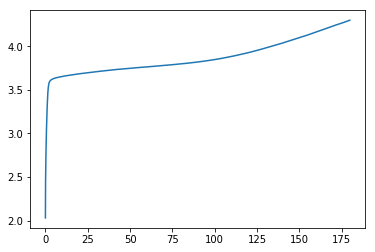

In [226]:
import matplotlib.pyplot as plt

#T_real = N_int*dt_int + (nstep-N_int)*dt
#print(T_real)

LiII = [0 for x in range(len(LiX))]
for i in range(len(LiX)):
  LiII[i]  = LiX[i]*Qs_max
#  print([i,LiII[i],Vltg[i]])

plt.plot(LiII, Vltg, '-')

#plt.plot(Qcell[:nstep], Ucell[:nstep], '-')

with open('ncm_mr25_lps3_I005.txt', 'w') as fout:
    for i in range(len(Qcell[:nstep])):
        fout.write('%s \t %s \n'%(Qcell[i], Ucell[i]))
        
#    for i in range(len(LiII)):
#        fout.write('%s \t %s \n'%(LiII, Vltg))

In [803]:
a=2
b=4
if a==1 and not b%2 :
    print(b)